# Fine-tuning AlexNet For Document Classification

### All the imports here

In [1]:
import sys
import os
import caffe
import numpy as np
from pylab import *
import tempfile
from PIL import Image
import lmdb
from random import shuffle
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

### Preprocess data

In [2]:
caffe_root = '../'
sys.path.insert(0, caffe_root + 'python')
caffe.set_device(0)
caffe.set_mode_gpu()

In [14]:
def deprocess_net_image(image):
    """
    deprocessing preprocessed images
    :param image to deprocess
    """
    image = image.copy()
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image[image < 0], image[image > 255] = 0, 255
    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)
    return image

def read_tif(file_path, new_width, new_height):
    """
    read single band tif file and resize it to (new_width, new_height)
    :param file_path image to read
    :param new_width new width
    :param new_height new height
    """
    try:
        img = Image.open(file_path).convert("L")
        img = img.resize((new_height, new_width),Image.ANTIALIAS)
        img_array = np.array(img)
        img.close()
    except Exception as e:
        print(e)
    return img_array

def list_imgs(imgs_directory, new_width=227, new_height=227):
    """
    load raw tif from given directory
    :param imgs_directory image directory
    :new_width
    :new_height
    :return labels, image matrix, and indexs of images in matrix
    """
    doc_images, labels, class_indexs = [], [], {}
    try:
        for directory in os.scandir(imgs_directory):
            directory_cls = []  # keep index for corresponding class
            class_name = directory.name.strip().lower()  # directory as class name
            for img in os.scandir(directory):
                if img.name.endswith(".tif"):
                    labels.append(class_name)  
                    doc_images.append(read_tif(img.path, new_width, new_width))
                    directory_cls.append(len(labels)-1)  # keep img index in corresponding class list
            class_indexs[class_name] = directory_cls
    except Exception as e:
        print(e)
    return labels, np.array(doc_images), class_indexs

def save_to_lmdb(path, map_size, rgb_img_arr_c1, indexes, num_labels):
    """
    save images to lmdb file
    :param path to save lmdb
    :param map_size for lmdb file
    :param rgb_img_arr_c1 3 bands image with channel first
    :param num_labels numerical encoded labels
    """
    env = lmdb.open(path, map_size=map_size)
    with env.begin(write=True) as transaction_object:
        for i in indexes:
            datum = caffe.proto.caffe_pb2.Datum()
            datum.channels = rgb_img_arr_c1.shape[1]
            datum.height = rgb_img_arr_c1.shape[2]
            datum.width = rgb_img_arr_c1.shape[3]
            datum.data = rgb_img_arr_c1[i].tobytes()
            datum.label = int(num_labels[i])
            str_id = '{:08}'.format(i)
            # The encode is only essential in Python 3
            transaction_object.put(str_id.encode('ascii'), datum.SerializeToString())
            
def test_trained_model(deploy_path, model_path, lmdb_test_path):
    """
    test trained caffe model
    :deploy_path deploy file
    :model_path trained model
    :lmdb_test_path test file
    """
    net = caffe.Net(deploy_path, model_path, caffe.TEST)
    count = 0
    correct = 0
    try:
        lmdb_env = lmdb.open(test_lmdb_path)
        lmdb_txn = lmdb_env.begin()
        lmdb_cursor = lmdb_txn.cursor()
    except Exception:
        print('Exception while reading lmdb file')
    correct_l, pred_l = [], []
    for key, value in lmdb_cursor:
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        label = int(datum.label)
        correct_l.append(label)
        flat_x = np.frombuffer(datum.data, dtype=np.uint8)
        x = flat_x.reshape(datum.channels, datum.height, datum.width)
        x = x.transpose(1, 2, 0) # to HWC
        datai = np.array([(x - np.array([123, 117, 104])).transpose(2, 0, 1)])
        out = net.forward_all(data=datai)
        plabel = int(out['prob'][0].argmax(axis=0))
        pred_l.append(plabel)
        count += 1
        iscorrect = label == plabel
        correct += (1 if iscorrect else 0)
    print("\n" + str(correct) + " out of " + str(count) + " were classified correctly")
    return correct_l, pred_l

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    title = 'Normalized confusion matrix'
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def bar_plot(k_v):
    """
    bar plot for label and corresponding number of images
    """
    f, ax = plt.subplots(figsize=(10, 5))
    plt.bar(k_v.keys(), k_v.values(), color='g')
    xlocs=[i for i in range(0, 10)]
    sorted_keys = sorted(k_v.keys()) # sort keys, according to the order sorted by bar
    for i, v in enumerate(sorted_keys):
        plt.text(xlocs[i] - 0.2, k_v[v] + 2, str(k_v[v]))
    plt.xlabel('categories')
    plt.ylabel('number of images')
    plt.show()

#### Load data

In [4]:
# get categorical labels of images, image matrix and indexes of images within different classes
labels, doc_images, class_indexs = list_imgs(caffe_root + 'data/imgs/')

In [5]:
# create numerical categorical labels
print('Number of unique labels %i' % len(class_indexs))
cat_num_labels = {}
for index, key in enumerate(class_indexs.keys()):
    cat_num_labels[key] = index
num_labels = [cat_num_labels[label] for label in labels]

Number of unique labels 10


Image dimension (227, 227)
Numerical code 0, categorical value memo


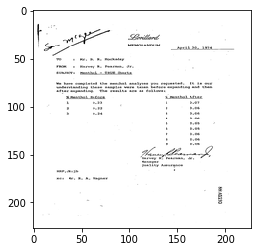

In [6]:
# show one image
image_index = 0
print('Image dimension (%i, %i)' % doc_images[image_index].shape)
print('Numerical code %i, categorical value %s' % (num_labels[image_index], labels[image_index]))
plt.imshow(np.array(doc_images[image_index]), cmap='gray')

In [8]:
# write label to folder
#with open(caffe_root + 'confs/pixel_mean_sub/labels.txt', 'w') as label_f:
#    for key, value in cat_num_labels.items():
#        label_f.write(key + ', ' + str(value) + '\n')

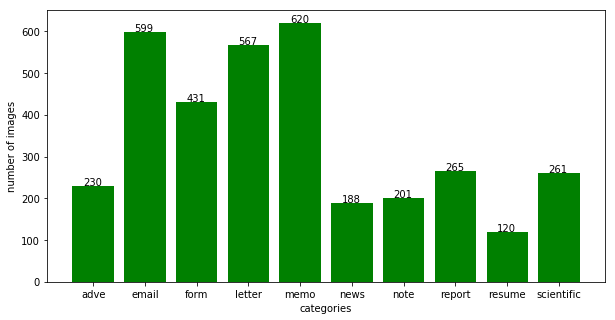

In [9]:
k_v = {}
for key, value in class_indexs.items():
    k_v[key] = len(value)
bar_plot(k_v)

#### Create image tensor with 3 channels, and switch channel to first

In [14]:
# create image with r, g, b channels
print('Original shape: ' + str(doc_images.shape))
rgb_img_arr = np.array([np.stack((img,)*3, axis=-1) for img in doc_images])
print('Three channel shape: ' + str(rgb_img_arr.shape))

Original shape: (3482, 227, 227)
Three channel shape: (3482, 227, 227, 3)


Channel first shape: (3482, 3, 227, 227)


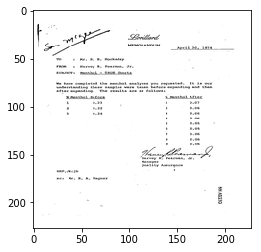

In [15]:
# push channel dimension first
rgb_img_arr_c1 = np.rollaxis(rgb_img_arr, 3, 1)
print('Channel first shape: ' + str(rgb_img_arr_c1.shape))
plt.imshow(deprocess_net_image(rgb_img_arr_c1[image_index]))

#### Set train, validation and test data

In [19]:
# randomly select 100 images from each class
class_img = 100
train_val_indexs = np.array([np.random.choice(value, 100, replace=False) for key, value in class_indexs.items()])
print(train_val_indexs.shape)

(10, 100)


In [23]:
# split into train and validation
train_indexs = train_val_indexs[:,:98]
val_indexs = train_val_indexs[:,98:]
print(train_indexs.shape, val_indexs.shape)

(10, 98) (10, 2)


In [32]:
# get image indexes for train, validation and test
train_f_indexes = list(train_indexs.flatten())
val_f_indexes = list(val_indexs.flatten())
train_val_indexs_flatten = train_f_indexes + val_f_indexes
test_f_indexes = list(set([i for i in range(len(labels))]).symmetric_difference(set(train_val_indexs_flatten)))
print('Number of images for train and validation: %i' % len(train_val_indexs_flatten))
print('Number of images for test: %i' % len(test_f_indexs))

Number of images for train and validation: 1000
Number of images for test: 2482


#### Check mean of original imagenet images

In [25]:
blob = caffe.proto.caffe_pb2.BlobProto()
mean_file = os.path.join(caffe_root, 'data/imagenet_mean.binaryproto')
data = open(mean_file , 'rb' ).read()
blob.ParseFromString(data)
arr = np.array(caffe.io.blobproto_to_array(blob))
mean=arr[0].mean(1).mean(1)
print(mean)

[ 104.00698793  116.66876762  122.67891434]


#### Save train, validation and test images

In [33]:
# save training
shuffle(train_f_indexes)
shuffle(val_f_indexes)
shuffle(test_f_indexes)
save_to_lmdb(os.path.join(caffe_root, 'data/tobacco3482_shuffle_train_lmdb'), doc_images.nbytes * 10, rgb_img_arr_c1, train_f_indexes, num_labels)
save_to_lmdb(os.path.join(caffe_root, 'data/tobacco3482_shuffle_val_lmdb'), doc_images.nbytes * 5, rgb_img_arr_c1, val_f_indexes, num_labels)
save_to_lmdb(os.path.join(caffe_root, 'data/tobacco3482_shuffle_test_lmdb'), doc_images.nbytes * 20, rgb_img_arr_c1, test_f_indexes, num_labels)

(3, 227, 227)


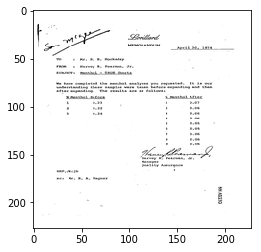

In [43]:
# check saved images
env = lmdb.open(os.path.join(caffe_root, 'data/tobacco3482_test_lmdb'), readonly=True)
with env.begin() as transaction_object:
    raw_datum = transaction_object.get(b'00000000')
datum = caffe.proto.caffe_pb2.Datum()
datum.ParseFromString(raw_datum)
flat_x = np.frombuffer(datum.data, dtype=np.uint8)
x = flat_x.reshape(datum.channels, datum.height, datum.width)
y = datum.label
print(x.shape)
plt.imshow(deprocess_net_image(x), cmap='gray')

### Test trained model

In [15]:
deploy_prototxt_file_path = os.path.join(caffe_root, 'confs/pixel_mean_sub_shuffle/deploy.prototxt')  # Network definition file
caffe_model_file_path = os.path.join(caffe_root, 'models/doc_alexnet_shuffle/caffe_alexnet_train_iter_20000.caffemodel') # Trained Caffe model file
test_lmdb_path = os.path.join(caffe_root, 'data/tobacco3482_shuffle_test_lmdb') # Test LMDB database path
correct_l, pred_l = test_trained_model(deploy_prototxt_file_path, caffe_model_file_path, test_lmdb_path)


1858 out of 2482 were classified correctly


In [16]:
print(len(correct_l), len(pred_l))

2482 2482


Normalized confusion matrix


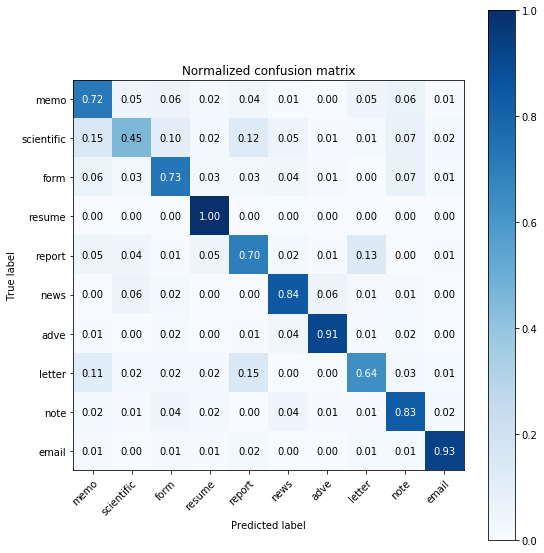

In [17]:
# Plot normalized confusion matrix
plot_confusion_matrix(correct_l, pred_l, classes=cat_num_labels.keys(), normalize=True, title='Normalized confusion matrix')